In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [612]:
#Read in Data
game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
video_footage_control = pd.read_csv('video_footage-control.csv')
video_footage_injury = pd.read_csv('video_footage-injury.csv')
video_review = pd.read_csv('video_review.csv')

In [613]:
NGS_2016_pre = pd.read_csv('NGS-2016-pre.csv')
NGS_2016_post = pd.read_csv('NGS-2016-post.csv')
NGS_2017_pre = pd.read_csv('NGS-2017-pre.csv')
NGS_2017_post = pd.read_csv('NGS-2017-post.csv')

In [120]:
NGS_2016_wk1_6 = pd.read_csv('NGS-2016-reg-wk1-6.csv')
NGS_2016_wk7_12 = pd.read_csv('NGS-2016-reg-wk7-12.csv')
NGS_2016_wk13_17 = pd.read_csv('NGS-2016-reg-wk13-17.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
NGS_2017_wk1_6 = pd.read_csv('NGS-2017-reg-wk1-6.csv')
NGS_2017_wk7_12 = pd.read_csv('NGS-2017-reg-wk7-12.csv')
NGS_2017_wk13_17 = pd.read_csv('NGS-2017-reg-wk13-17.csv')

In [121]:
NGS_2016 = pd.concat([NGS_2016_wk1_6, NGS_2016_wk7_12, NGS_2016_wk13_17])

In [ ]:
NGS_2017 = pd.concat([NGS_2017_wk1_6, NGS_2017_wk7_12, NGS_2017_wk13_17])

In [ ]:
NGS_df = pd.concat([NGS_2016, NGS_2017])

In [ ]:
len(NGS_df)

In [ ]:
NGS_df.head()

In [ ]:
test_plot = NGS_2016.loc[(NGS_2016.PlayID == 2035) & (NGS_2016.GSISID == 27675)].sort_values('Time')

In [ ]:
player_punt.loc[player_punt.GSISID == 27675]

In [ ]:
player_punt.head()

In [ ]:
play_player_role.loc[(play_player_role.GSISID == 27675) & (play_player_role.PlayID == 2035)]

In [ ]:
play_info.head()

In [ ]:
video_review.head()

In [ ]:
video_footage_injury.iloc[0,9]

#### Who's getting hurt?

In [ ]:
merged_df = video_review.merge(play_player_role, how= 'left', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [ ]:
player_punt.loc[player_punt.GSISID == 32482]

In [ ]:
play_player_role.loc[(play_player_role.GSISID == 29343) & (play_player_role.PlayID == 2587)]

In [ ]:
merged_df.Role.value_counts()

In [ ]:
len(video_footage_injury)

In [ ]:
ax = plt.plot(test_plot['x'],test_plot['y'])

In [ ]:
gunner_df = NGS_2016_pre.loc[(NGS_2016_pre.GameKey == 5) & (NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 31057)].sort_values('Time')

In [ ]:
min(gunner_df['Time'])

In [ ]:
max(gunner_df['Time'])

In [ ]:
gunner_df.head(11).dis.sum() * 2.045

In [ ]:
gunner_df.head()

In [ ]:
gunner_df['dis_per_second'] = gunner_df.dis * 10
gunner_df['dis_mph'] = gunner_df['dis_per_second'] * 2.0455

In [ ]:
print(gunner_df.dis_mph[200:250])

In [ ]:
play_player_role.loc[(play_player_role.GameKey == 5) & (play_player_role.PlayID == 3129) & (play_player_role.GSISID == 31057)]

In [ ]:
ax1 = plt.subplot()
ax1.plot(gunner_df['x'], gunner_df['y'])
ax1.set_xlim([0,120])
ax1.set_ylim([0,53.3])

In [ ]:
max(NGS_2016_wk1_6['y'])

In [ ]:
play_info['fair_catch'] = play_info.PlayDescription.str.contains('fair catch')

In [ ]:
play_info.loc[play_info.fair_catch == True].merge(video_review)

In [ ]:
video_footage_injury.loc[video_footage_injury.playid == 2918]

In [ ]:
video_footage_injury.head()

### Does speed correlate with injury?

In [ ]:
video_review.head()

In [ ]:
injury_ngs = video_review.merge(NGS_2016, how ='inner', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [ ]:
injury_ngs['dis_per_second'] = injury_ngs.dis * 10
injury_ngs['dis_mph'] = injury_ngs.dis_per_second * 2.0455

In [ ]:
injury_ngs.groupby('PlayID')['dis_mph'].agg(max)

In [ ]:
play_info.head()

In [ ]:
play_info = play_info.merge(video_review[['GameKey','PlayID','GSISID']], how = 'left', left_on = ['GameKey','PlayID'], right_on = ['GameKey','PlayID'])

In [ ]:
play_info['injury'] = play_info.GSISID.apply(lambda x: 0 if pd.isnull(x) else 1)

In [ ]:
play_info.fair_catch.value_counts(normalize = True)

In [ ]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 1])

In [ ]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 0])

In [ ]:
fair_catches = play_info.loc[play_info.fair_catch == 1]
non_fair_catches = play_info.loc[play_info.fair_catch == 0]

In [ ]:
len(fair_catches.loc[fair_catches.injury == 1]) / float(len(fair_catches)) * 100

In [ ]:
len(non_fair_catches.loc[non_fair_catches.injury == 1]) / float(len(non_fair_catches)) * 100

In [ ]:
(.7-.12) / .12

#### Nearly 5 times more likely to have an injury when there is an actual return

In [ ]:
import plotly

In [ ]:
import plotly.graph_objs as go
from plotly import offline
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mtodisco10', api_key='bCfUmq5FralbymKXY4uX')

In [ ]:
def load_layout():
    """
    Returns a dict for a Football themed Plot.ly layout 
    """
    layout = dict(
        title = "Player Activity",
        plot_bgcolor='darkseagreen',
        showlegend=True,
        xaxis=dict(
            autorange=False,
            range=[0, 120],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            tickmode='array',
            tickvals=[10,20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
            ticktext=['Goal', 10, 20, 30, 40, 50, 40, 30, 20, 10, 'Goal'],
            showticklabels=True
        ),
        yaxis=dict(
            title='',
            autorange=False,
            range=[-3.3,56.3],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            showticklabels=False
        ),
        shapes=[
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=0,
                x1=120,
                y1=0,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=53.3,
                x1=120,
                y1=53.3,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=10,
                y0=0,
                x1=10,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=20,
                y0=0,
                x1=20,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=30,
                y0=0,
                x1=30,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=40,
                y0=0,
                x1=40,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=50,
                y0=0,
                x1=50,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=60,
                y0=0,
                x1=60,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=70,
                y0=0,
                x1=70,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=80,
                y0=0,
                x1=80,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=90,
                y0=0,
                x1=90,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=100,
                y0=0,
                x1=100,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=110,
                y0=0,
                x1=110,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            )
        ]
    )
    return layout

layout = load_layout()

In [ ]:
# Loading and plotting functions

def load_plays_for_game(GameKey):
    """
    Returns a dataframe of play data for a given game (GameKey)
    """
    play_information = pd.read_csv('play_information.csv')
    play_information = play_information[play_information['GameKey'] == GameKey]
    return play_information


def load_game_and_ngs(ngs_file=None, GameKey=None):
    """
    Returns a dataframe of player movements (NGS data) for a given game
    """
    if ngs_file is None:
        print("Specifiy an NGS file.")
        return None
    if GameKey is None:
        print('Specify a GameKey')
        return None
    # Merge play data with NGS data    
    plays = load_plays_for_game(GameKey)
    ngs = pd.read_csv(ngs_file, low_memory=False)
    merged = pd.merge(ngs, plays, how="inner", on=["GameKey", "PlayID", "Season_Year"])
    return merged


def plot_play(game_df, PlayID, player1=None, player2=None, custom_layout=False):
    """
    Plots player movements on the field for a given game, play, and two players
    """
    game_df = game_df[game_df.PlayID==PlayID]
    
    GameKey=str(pd.unique(game_df.GameKey)[0])
    HomeTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[0]
    VisitingTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[1]
    YardLine = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)]['YardLine'].iloc[0]
    
    traces=[]   
    if (player1 is not None) & (player2 is not None):
        game_df = game_df[ (game_df['GSISID']==player1) | (game_df['GSISID']==player2)]
        for player in pd.unique(game_df.GSISID):
            player = int(player)
            trace = go.Scatter(
                x = game_df[game_df.GSISID==player].x,
                y = game_df[game_df.GSISID==player].y,
                name='GSISID '+str(player),
                mode='markers'
            )
            traces.append(trace)
    else:
        print("Specify GSISIDs for player1 and player2")
        return None
    
    if custom_layout is not True:
        layout = load_layout()
        layout['title'] =  HomeTeam + \
        ' vs. ' + VisitingTeam + \
        '<br>Possession: ' + \
        YardLine.split(" ")[0] +'@'+YardLine.split(" ")[1]
    data = traces
    fig = dict(data=data, layout=layout)
    play_description = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)].iloc[0]["PlayDescription"]
    print("\n\n\t",play_description)
    #py.iplot(fig,filename='jupyter-table1')
    offline.iplot(fig)

In [ ]:
game280 = load_game_and_ngs('NGS-2016-reg-wk13-17.csv',GameKey=280)

In [ ]:
plot_play(game_df=game280, PlayID=2918, player1=32120, player2=32725)

In [ ]:
video_review.head()

In [ ]:
player = NGS_2016_pre.loc[(NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 31057) 
                          & (NGS_2016_pre.GameKey == 5)] 


In [ ]:
partner = NGS_2016_pre.loc[(NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 32482) & 
                           (NGS_2016_pre.GameKey == 5)] 

In [ ]:
player.loc[player.Event.notnull()].sort_values('Time')

In [ ]:
partner.loc[partner.Time == '2016-08-12 02:07:48.300']

In [ ]:
player = player[['x','y','dis']]

In [ ]:
partner.sort_values('Time').head()

In [ ]:
player_partner 

In [ ]:
next_gen_data.head()

In [ ]:
#MAX_Speed, AVG_Speed

In [ ]:
next_gen_data = pd.read_csv('NGS-2016-pre.csv')

In [ ]:
playId = 3129
gameKey = 5
gsisid = 31057

In [ ]:
play_info.loc[(play_info.GameKey == gameKey) & (play_info.PlayID == playId)]

In [ ]:
video_review.loc[(video_review.PlayID == playId)]

In [2]:
def get_speed(ng_data, playId, gameKey, player, partner):
    ng_data = pd.read_csv(ng_data)
    ng_data['mph'] = convert_to_mph(ng_data['dis'], 20.455)
    player_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                               & (ng_data.GSISID == player)].sort_values('Time')
    partner_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                              & (ng_data.GSISID == partner)].sort_values('Time')
    player_grouped = player_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    player_grouped['involvement'] = 'player_injured'
    partner_grouped = partner_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    partner_grouped['involvement'] = 'primary_partner'
    return pd.concat([player_grouped, partner_grouped], axis = 0)[['involvement',
                                                                   'max_mph',
                                                                   'avg_mph']].reset_index(drop=True)

In [3]:
def convert_to_mph(dis_vector, converter):
    mph_vector = dis_vector * converter
    return mph_vector

In [4]:
get_speed('NGS-2016-pre.csv', 3129, 5, 31057, 32482)

,involvement,max_mph,avg_mph
0,player_injured,18.40950,5.229332
1,primary_partner,15.75035,4.083396


### Identify 2 gunner blockers

In [84]:
# for each game,  count how many players are gunner blockers.
# does this correlate with more returns?  more injuries?

In [122]:
gunners = NGS_2016

In [123]:
gunners.head()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
0,2016,66,2035,27675.0,2016-09-09 02:22:30.700,71.959999,30.809999,0.55,196.910004,282.000000,NaN
1,2016,66,2035,31550.0,2016-09-09 02:22:30.700,53.910000,29.980000,0.82,185.470001,275.890015,NaN
2,2016,66,2035,30463.0,2016-09-09 02:22:30.700,57.770000,22.260000,0.71,176.639999,267.309998,NaN
3,2016,66,2035,22824.0,2016-09-09 02:22:30.800,74.070000,26.910000,0.08,167.850006,19.540001,NaN
4,2016,66,2035,32994.0,2016-09-09 02:22:30.800,56.540001,33.080002,0.86,193.350006,285.429993,NaN


In [124]:
rank_df = gunners.loc[(gunners.Season_Year == 2016) & (gunners.Event == 'ball_snap')].sort_values('Time')

In [126]:
rank_df['rank'] = rank_df.groupby(['Season_Year','GameKey','PlayID','GSISID']).cumcount() +1

In [127]:
rank_df = rank_df.loc[rank_df['rank'] == 1]

In [128]:
g_merge = rank_df.merge(play_player_role, how = 'inner', on = ['Season_Year','GameKey','PlayID','GSISID'])

In [130]:
# ax1 = plt.subplot()
# ax1.scatter(g_merge.loc[g_merge.Event == 'line_set']['x'].reset_index(drop=True)
#             ,g_merge.loc[g_merge.Event == 'line_set']['y'].reset_index(drop=True))
# ax1.set_xlim([0,120])
# ax1.set_ylim([0,53.3])
# for i, txt in enumerate(g_merge.loc[g_merge.Event == 'line_set'].reset_index(drop=True)['Role']):
#     ax1.annotate(txt,xy=(g_merge.loc[g_merge.Event == 'line_set']['x'].reset_index(drop=True)[i]
#                            ,g_merge.loc[g_merge.Event == 'line_set']['y'].reset_index(drop=True)[i]))

In [131]:
return_roles = ['PDL1','PDL2','PDL3','PDL4','PDL5','PDL6','PDM','PDR1','PDR2','PDR3','PDR4','PDR5','PDR6'
                ,'PFB','PLL','PLL1','PLL2','PLL3','PLM','PLM1','PLR','PLR1','PLR2','PLR3','PR','VL','VLi'
                ,'VLo','VR','VRi','VRo']

coverage_roles = ['GL','GLi','GLo','GR','GRi','GRo','P','PC','PLG','PLS','PLT','PLW','PPL','PPLi','PPLo'
                 ,'PPR','PPRi','PPRo','PRG','PRT','PRW']

In [132]:
gunner_blockers = ['VL','VLi','VLo','VR','VRi','VRo']

In [133]:
g_pre_snap = g_merge.loc[(g_merge['Role'].isin(gunner_blockers)) & (g_merge['Event'] == 'ball_snap')]

In [139]:
gunner_blockers_per_play = g_pre_snap.groupby(['Season_Year','GameKey','PlayID'], as_index=False)['Role'] \
    .agg({'gunner_blocker_count': 'count'})\
    .sort_values('gunner_blocker_count', ascending =False)

In [145]:
gunner_blockers_merged = gunner_blockers_per_play.merge(play_info, how ='left', on = ['Season_Year','GameKey','PlayID'])

In [146]:
gunner_blockers_merged['fair_catch'] = gunner_blockers_merged.PlayDescription.str.contains('fair catch')

In [150]:
gunner_summary = gunner_blockers_merged.groupby(['gunner_blocker_count'], as_index = False)['fair_catch'].agg([sum,'count'])

In [153]:
gunner_summary['perc'] = gunner_summary['sum'] / gunner_summary['count']

In [154]:
gunner_summary

,sum,count,perc
gunner_blocker_count,,,
1,10.0,31,0.322581
2,460.0,1351,0.340489
3,151.0,751,0.201065
4,31.0,236,0.131356
5,0.0,1,0.000000


In [168]:
gunner_summary_injury = gunner_blockers_merged.merge(video_footage_injury, how='inner', 
                             left_on = ['Season_Year','GameKey','PlayID'],
                            right_on = ['season','gamekey','playid']) \
                            .groupby(['gunner_blocker_count'], as_index = False)['fair_catch'].agg([sum,'count'])

In [169]:
gunner_summary_injury['perc'] = gunner_summary_injury['sum'] / gunner_summary_injury['count']

In [170]:
gunner_summary_injury

,sum,count,perc
gunner_blocker_count,,,
2,False,4,0.000000
3,True,6,0.166667
4,False,3,0.000000


In [156]:
video_footage_injury.head()

,season,Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,PREVIEW LINK (5000K)
0,2016,Pre,2,Chicago Bears,Denver Broncos,3,(3:44) (Punt formation) P.O'Donnell punts 58 y...,5,3129,http://a.video.nfl.com//films/vodzilla/153233/...
1,2016,Pre,3,Tennessee Titans,Carolina Panthers,3,(5:52) (Punt formation) K.Redfern punts 36 yar...,21,2587,http://a.video.nfl.com//films/vodzilla/153234/...
2,2016,Pre,3,Washington Redskins,New York Jets,1,"(4:46) L.Edwards punts 51 yards to WAS 27, Cen...",29,538,http://a.video.nfl.com//films/vodzilla/153235/...
3,2016,Pre,4,New York Jets,New York Giants,2,"(8:29) B.Wing punts 44 yards to NYJ 10, Center...",45,1212,http://a.video.nfl.com//films/vodzilla/153236/...
4,2016,Pre,5,Detroit Lions,Buffalo Bills,1,"(:38) C.Schmidt punts 46 yards to DET 8, Cente...",60,905,http://a.video.nfl.com//films/vodzilla/153237/...


In [182]:
play_player_role.loc[(play_player_role.Season_Year == 2016) & (play_player_role.GameKey == 280)
                     & (play_player_role.PlayID == 2918)]

,Season_Year,GameKey,PlayID,GSISID,Role
11350,2016,280,2918,26725,PRG
12552,2016,280,2918,27654,GL
19108,2016,280,2918,28029,PDR2
19998,2016,280,2918,28069,GR
31610,2016,280,2918,29304,P
39810,2016,280,2918,29510,PDR3
40499,2016,280,2918,31491,PDL2
53446,2016,280,2918,29959,PLS
65871,2016,280,2918,31075,PDL1
66795,2016,280,2918,31085,PDL4


In [280]:
test_play = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .sort_values('Time').reset_index(drop=True)

In [281]:
from datetime import datetime

In [282]:
single_play_events = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .groupby(['Time','Event'], as_index=False)\
    .count().sort_values('Time')

single_play_events['datetime'] = pd.to_datetime(single_play_events['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [283]:
test_play['Time'] = pd.to_datetime(test_play['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [346]:
val = single_play_events.loc[single_play_events.Event == 'punt']['datetime']  \
              - pd.Timedelta(seconds=4)

In [347]:
import math

In [348]:
from scipy.spatial import distance

In [349]:
def euclid_distance(x1, y1, x2, y2):
  # Euclidean distance between points.
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [350]:
test_returner = test_play.loc[(test_play.Event == 'fair_catch') & (test_play.GSISID == 33127)].reset_index(drop=True)

In [356]:
test_returner['x'], test_returner['y']

(0    40.630001
 Name: x, dtype: float64, 0    33.330002
 Name: y, dtype: float64)

In [352]:
test_players = test_play.loc[test_play.Time ==val.reset_index(drop=True)[0]].reset_index()

In [353]:
dist_lst = []
for i in range(0, len(test_players)):
    coords = test_players['x'][i], test_players['y'][i]
    dist = euclid_distance(test_returner['x'][0], test_returner['y'][0], coords[0], coords[1])
    dist_lst.append(dist)

In [354]:
test_players['dist_lst'] = dist_lst

In [344]:
test_players.head()

,index,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event,dist_lst
0,3623,2016,280,2918,32864.0,2016-12-18 20:20:50.300,90.400002,27.950001,0.05,163.919998,99.690002,NaN,50.059938
1,3624,2016,280,2918,33127.0,2016-12-18 20:20:50.300,30.549999,30.309999,0.04,350.970001,45.660000,NaN,10.522683
2,3625,2016,280,2918,31085.0,2016-12-18 20:20:50.300,88.720001,30.600000,0.08,8.160000,113.750000,NaN,48.167427
3,3626,2016,280,2918,28069.0,2016-12-18 20:20:50.300,90.739998,45.450001,0.02,179.940002,284.640015,NaN,51.554885
4,3627,2016,280,2918,31600.0,2016-12-18 20:20:50.300,87.919998,10.930000,0.05,16.260000,331.739990,NaN,52.326895


In [365]:
NGS_2016.Event.value_counts()

play_submit                 93577
punt_play                   61205
ball_snap                   52983
punt                        52437
line_set                    50806
punt_received               23499
tackle                      18051
penalty_flag                17283
fair_catch                  14863
out_of_bounds                9931
penalty_accepted             9238
punt_downed                  7862
touchback                    3486
huddle_start_offense         2050
fumble                       1968
huddle_break_offense         1861
fumble_offense_recovered     1570
timeout_tv                   1487
fumble_defense_recovered     1021
man_in_motion                 753
touchdown                     512
shift                         419
penalty_declined              322
punt_blocked                  285
punt_fake                     265
kick_received                 221
run                           199
pass_forward                  155
pass_outcome_caught           111
pass_lateral  

### Calculate hang time of punts

In [391]:
punt_event = NGS_2016.loc[NGS_2016.Event == 'punt'].groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
punt_event.rename(columns = {'Time':'punt_time'}, inplace=True)
punt_event['punt_time'] = pd.to_datetime(punt_event['punt_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [392]:
received_event = NGS_2016.loc[(NGS_2016.Event == 'punt_received') | (NGS_2016.Event == 'fair_catch')].groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
received_event.rename(columns = {'Time':'received_time'}, inplace=True)
received_event['received_time'] = pd.to_datetime(received_event['received_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [393]:
punt_df = punt_event.merge(received_event, how='inner', on = ['Season_Year','GameKey','PlayID'])

In [397]:
punt_df['hang_time'] = punt_df['received_time'] - punt_df['punt_time']

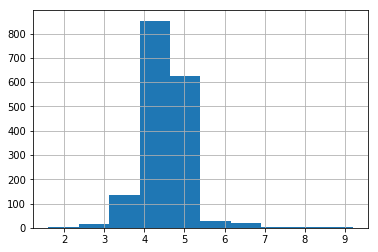

In [423]:
(punt_df['hang_time'].astype(int) / 1000000000).hist()

In [440]:
str(punt_df['hang_time'].mean().seconds) + '.' + str(punt_df['hang_time'].mean().microseconds)[:2]

'4.53'

In [441]:
str(punt_df['hang_time'].median().seconds) + '.' + str(punt_df['hang_time'].median().microseconds)[:2]

'4.50'

### Calculate distance between returner and closest coverage man at every half of a second

In [536]:
test_play = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .sort_values('Time').reset_index(drop=True)

In [537]:
test_play_merged = test_play.merge(play_player_role, how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
test_play_merged['Time'] = pd.to_datetime(test_play_merged['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [569]:
punt_event_time = test_play_merged.loc[test_play_merged.Event == 'punt'].Time.min()
receiving_event_time = test_play_merged.loc[(test_play_merged.Event == 'punt_received') | (test_play_merged.Event == 'fair_catch')].Time.min()

In [570]:
coverage_test = test_play_merged.loc[test_play_merged['Role'].isin(coverage_roles)].sort_values('Time')
coverage_test.rename(columns={'x':'cov_x', 
                              'y': 'cov_y',
                              'GSISID': 'cov_GSISID',
                              'dis': 'cov_dis',
                              'o': 'cov_o',
                              'dir': 'cov_dir',
                              'Role': 'cov_Role'
                             }, inplace=True)

In [571]:
returner_test = test_play_merged.loc[test_play_merged['Role'] == 'PR'].sort_values('Time')
returner_test.rename(columns={'x':'ret_x', 
                              'y': 'ret_y',
                              'GSISID': 'ret_GSISID',
                              'dis': 'ret_dis',
                              'o': 'ret_o',
                              'dir': 'ret_dir',
                              'Role': 'ret_Role'
                             }, inplace=True)

returner_test = returner_test.drop('Event', axis = 1)

In [572]:
cov_ret = coverage_test.merge(returner_test, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])

In [573]:
cov_ret['dis_from_ret'] = ((cov_ret['cov_x'] -  cov_ret['ret_x']) ** 2 + (cov_ret['cov_y'] -  cov_ret['ret_y']) ** 2).apply(np.sqrt)

In [574]:
cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=20))].sort_values('dis_from_ret')

,Season_Year,GameKey,PlayID,cov_GSISID,Time,cov_x,cov_y,cov_dis,cov_o,cov_dir,Event,cov_Role,ret_GSISID,ret_x,ret_y,ret_dis,ret_o,ret_dir,ret_Role,dis_from_ret
4045,2016,280,2918,26725,2016-12-18 20:21:12.300,44.700001,41.959999,0.14,266.220001,353.890015,NaN,PRG,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,17.819585
4041,2016,280,2918,32171,2016-12-18 20:21:12.300,52.720001,38.139999,0.30,326.140015,52.080002,NaN,PLG,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,20.196734
4040,2016,280,2918,32968,2016-12-18 20:21:12.300,38.639999,47.740002,0.23,285.480011,18.980000,NaN,PRT,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,21.689834
4042,2016,280,2918,28069,2016-12-18 20:21:12.300,43.759998,52.619999,0.08,305.440002,49.320000,NaN,GR,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,27.448525
4043,2016,280,2918,29304,2016-12-18 20:21:12.300,47.970001,54.040001,0.14,132.369995,242.970001,NaN,P,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,30.162470
4044,2016,280,2918,32864,2016-12-18 20:21:12.300,64.199997,38.250000,0.30,240.919998,339.929993,NaN,PLT,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,30.260132
4037,2016,280,2918,29959,2016-12-18 20:21:12.300,39.840000,56.459999,0.08,330.589996,23.990000,NaN,PLS,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,30.487938
4039,2016,280,2918,27654,2016-12-18 20:21:12.300,69.470001,20.450001,0.17,246.100006,330.309998,NaN,GL,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,33.500214
4047,2016,280,2918,32525,2016-12-18 20:21:12.300,48.400002,59.369999,0.14,281.480011,356.160004,NaN,PRW,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,35.291184
4038,2016,280,2918,31731,2016-12-18 20:21:12.300,51.820000,58.180000,0.16,284.950012,10.730000,NaN,PPR,33127,36.459999,26.16,0.1,187.300003,296.850006,PR,35.513519


In [575]:
punt_event_time + pd.Timedelta(seconds=4)

Timestamp('2016-12-18 20:20:56.300000')

In [604]:
dist_dict = {}

In [605]:
dist_dict['2918'] = {}

In [606]:
dist_dict

{'2918': {}}

In [607]:
for i in range(1, 5):
    time_df = cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=i))].sort_values('dis_from_ret').reset_index()
    cov_role = time_df['cov_Role'][0]
    distance = time_df['dis_from_ret'][0]
    dist_dict['2918'][i] = [cov_role, distance]

In [608]:
dist_dict

{'2918': {1: ['GR', 46.331641621495713],
  2: ['GR', 39.315162744671717],
  3: ['GR', 26.873468750720061],
  4: ['GR', 12.691355358037008]}}

In [627]:
play_info_2016_pre = play_info.loc[play_info['Season_Year'] == 2016]

In [714]:
dist_dict = {}

In [715]:
for i in range(0, len(play_info_2016_pre)):
    season_key = play_info_2016_pre['Season_Year'][i]
    game_key = play_info_2016_pre['GameKey'][i]
    play_id = play_info_2016_pre['PlayID'][i]
    identifier = '{}_{}_{}'.format(season_key, game_key, play_id)
    if game_key in NGS_2016_pre.GameKey and play_id in NGS_2016_pre.PlayID:
        test_play = NGS_2016_pre.loc[(NGS_2016_pre.GameKey == game_key) & (NGS_2016_pre.PlayID == play_id)].sort_values('Time').reset_index(drop=True)
        test_play_merged = test_play.merge(play_player_role, how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
        if len(test_play_merged) > 0:
            test_play_merged['Time'] = pd.to_datetime(test_play_merged['Time'], format='%Y-%m-%d %H:%M:%S.%f')
            punt_event_time = test_play_merged.loc[test_play_merged.Event == 'punt'].Time.min()
            receiving_event_time = test_play_merged.loc[(test_play_merged.Event == 'punt_received') | (test_play_merged.Event == 'fair_catch')].Time.min()
            coverage_test = test_play_merged.loc[test_play_merged['Role'].isin(coverage_roles)].sort_values('Time')
            coverage_test.rename(columns={'x':'cov_x', 
                                      'y': 'cov_y',
                                      'GSISID': 'cov_GSISID',
                                      'dis': 'cov_dis',
                                      'o': 'cov_o',
                                      'dir': 'cov_dir',
                                      'Role': 'cov_Role'
                                     }, inplace=True)
            returner_test = test_play_merged.loc[test_play_merged['Role'] == 'PR'].sort_values('Time')
            returner_test.rename(columns={'x':'ret_x', 
                                      'y': 'ret_y',
                                      'GSISID': 'ret_GSISID',
                                      'dis': 'ret_dis',
                                      'o': 'ret_o',
                                      'dir': 'ret_dir',
                                      'Role': 'ret_Role'
                                     }, inplace=True)
            returner_test = returner_test.drop('Event', axis = 1)
            cov_ret = coverage_test.merge(returner_test, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])
            cov_ret['dis_from_ret'] = ((cov_ret['cov_x'] -  cov_ret['ret_x']) ** 2 + (cov_ret['cov_y'] -  cov_ret['ret_y']) ** 2).apply(np.sqrt)
            dist_dict[identifier] = {}
            for i in range(1, 7):
                time_df = cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=i))].sort_values('dis_from_ret').reset_index(drop=True)
                if len(time_df) > 0:
                    cov_role = time_df['cov_Role'][0]
                    distance = time_df['dis_from_ret'][0]
                    dist_dict[identifier][i] = [cov_role, distance]

In [711]:
len(play_info_2016_pre)

3285

In [738]:
for k, v in dist_dict['2016_3_455'].items():
    if k == 5:
        print(v)

['GR', 1.6888176726731501]


In [739]:
for key in dist_dict.keys():
    for k, v in dist_dict[key].items():
        if k == 5:
            print(v)

['GR', 1.6888176726731501]
['GL', 4.878942923576485]
['PPR', 1.2660568553939779]
['PLG', 1.8266076560598183]
['PPR', 1.2688918846863082]
['GR', 1.1063447969864666]
['GL', 4.2223798566029904]
['GR', 2.1397420410412127]
['PRT', 7.2120029689425733]
['PLT', 1.067942117444203]
['PPR', 2.7854798516864161]
['GR', 19.243611652884439]
['GR', 4.2154942870026657]
['GR', 11.41504984827653]
['GR', 9.5302610185278276]
['GL', 4.6399666370640684]
['PLS', 2.3026243890764655]
['GR', 0.32984813548142117]
['GR', 6.7350193327564023]
['GR', 14.580283234813164]
['GL', 12.622049536310346]
['GL', 6.6060100288518901]
['GL', 10.746818151028021]
['GL', 14.428061587598759]
['GL', 4.0909898411705008]
['GL', 1.9332889848218022]
['GR', 11.934462630180686]
['PPR', 3.375346988505]
['GL', 2.1029778575047153]
['GL', 2.4894368842096548]
['GR', 6.2502002958628378]
['GL', 36.75312351327679]
['GL', 47.425193669625131]
['PRT', 25.105002532211355]
['PRT', 7.4945091317892629]
['GR', 5.2501896534906329]
['GR', 7.7400260790311552

In [719]:
dist_dict['2016_5_3129']

{1: ['GR', 39.247853120400869],
 2: ['GR', 32.537285175377846],
 3: ['GR', 27.900847591582924],
 4: ['GR', 20.883736804171015],
 5: ['GR', 11.934462630180686],
 6: ['GR', 4.3511496636039633]}